<a href="https://colab.research.google.com/github/danielcti/data-science-project/blob/colabIgor/dataVisualizationNetflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importando bibliotecas que julgamos necessárias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime as dt
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from warnings import filterwarnings
filterwarnings('ignore')


In [2]:
df = pd.read_csv("netflix_titles.csv")
print('Setup Complete')

Setup Complete


##Primeiramente vamos ver o que temos nos nossos dados carregados, para assim possibilitar nossa análise descritiva

In [3]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
df.tail()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7782,s7783,Movie,Zozo,Josef Fares,"Imad Creidi, Antoinette Turk, Elias Gergi, Car...","Sweden, Czech Republic, United Kingdom, Denmar...","October 19, 2020",2005,TV-MA,99 min,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...
7783,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...
7784,s7785,Movie,Zulu Man in Japan,NaN,Nasty C,NaN,"September 25, 2020",2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast..."
7785,s7786,TV Show,Zumbo's Just Desserts,NaN,"Adriano Zumbo, Rachel Khoo",Australia,"October 31, 2020",2019,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...
7786,s7787,Movie,ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS,Sam Dunn,NaN,"United Kingdom, Canada, United States","March 1, 2020",2019,TV-MA,90 min,"Documentaries, Music & Musicals",This documentary delves into the mystique behi...


Agora iremos ver o tamanho dos nossos dados:

In [5]:
df.shape

(7787, 12)

Podemos ver que temos 12 atributos com 7787 instâncias 

### Podemos ver que nossos dados já estão separados entre séries(*TV Show*) e filmes (*Movie*). Então, até o momento, não precisamos aplicar nenhuma função para definir entre séries e filmes.

##Agora, dando início ao nosso pré-processamento dos dados






### Vamos agora tratar nossas instâncias, primeiramente verificando caso tenhamos dados ausentes. Caso positivo iremos tratá-los da maneira cabível, seja excluindo, substituindo, ou alterando da melhor maneira possível.

In [6]:
df.isnull().sum()/(len(df))*100

show_id          0.000000
type             0.000000
title            0.000000
director        30.679337
cast             9.220496
country          6.510851
date_added       0.128419
release_year     0.000000
rating           0.089893
duration         0.000000
listed_in        0.000000
description      0.000000
dtype: float64

Primeiramente veremos quais as instâncias de *types* para que possamos facilitar nosso tratamento para *director* que possuem 30% de dados ausentes.

In [7]:
df.type.unique()

array(['TV Show', 'Movie'], dtype=object)

Como só temos duas instâncias de *type*, obsevadas logo acima e que, além disso, sabemos que em 'TV Show' os diretores variam por episódio fazendo sentido não serem guardados tais dados. Dessa forma, iremos dividir em dois datasets, dfMovie e dfShow, para checar se essa suposição de fato se prova verdadeira.

In [8]:
dfMovie = df[(df.type == 'Movie')]
dfShow = df[(df.type == 'TV Show')]

In [9]:
dfShow.isnull().sum()/(len(dfShow))*100

show_id          0.000000
type             0.000000
title            0.000000
director        92.365145
cast            12.116183
country         11.493776
date_added       0.414938
release_year     0.000000
rating           0.082988
duration         0.000000
listed_in        0.000000
description      0.000000
dtype: float64

In [10]:
dfMovie.isnull().sum()/(len(dfMovie))*100

show_id         0.000000
type            0.000000
title           0.000000
director        3.031430
cast            7.922633
country         4.277478
date_added      0.000000
release_year    0.000000
rating          0.092989
duration        0.000000
listed_in       0.000000
description     0.000000
dtype: float64

De fato, nossa suposição se tornou em partes verdadeira, visto que a feature *director* apresentou 92% de dados ausentes para dfShow e apenas 3% para dfMovie.
> Tendo isso em vista, poderíamos trabalhar com dois datasets onde vamos excluir o atributo em dfShows e apenas substituí-los em dfMovies ou substituir todos os valores ausentes por 'desconhecido'.


vamos seguir com a segunda opção por enquanto

In [11]:
df['director']=df['director'].fillna('desconhecido')

Agora com relação ao atributo cast, iremos tratar da mesma forma que *director*

In [12]:
df['cast']=df['cast'].fillna('desconhecido')

Com relação a *country* vamos substituir pela moda, assim como em *date_added*

In [13]:
df['country']=df['country'].fillna(df['country'].mode()[0])
df['rating']=df['rating'].fillna(df['rating'].mode()[0])
df['date_added']=df['date_added'].fillna(df['date_added'].mode()[0])

Com relação a *rating* iremos alterar inserir novos atributos utilizando o fancyimput do KNN quanto tratarmos os tipos dos nossos dados.

In [14]:
df.isnull().sum()/(len(df))*100

show_id         0.0
type            0.0
title           0.0
director        0.0
cast            0.0
country         0.0
date_added      0.0
release_year    0.0
rating          0.0
duration        0.0
listed_in       0.0
description     0.0
dtype: float64

Como podemos ver, todos os dados ausentes foram tratados.

## Realizando agora a definição de tipos, vamos primeiro analisá-los para podermos decidir quais ações tomar

In [15]:
df.dtypes

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

###Como pudemos notar ao mostrar o nosso dataset inicialmente o campo *country* é composto de uma lista de países, porém será mais prático trabalhar apenas com o país principal, que neste caso consideramos o primeiro da lista. Então iremos adicionar a coluna *main_country* ao data frame.

In [16]:
df['main_country']=df['country'].apply(lambda x: x.split(",")[0])
df['main_country']

0               Brazil
1               Mexico
2            Singapore
3        United States
4        United States
             ...      
7782            Sweden
7783             India
7784     United States
7785         Australia
7786    United Kingdom
Name: main_country, Length: 7787, dtype: object

### Com relação a *duration*, teremos que tratar o nosso dataset para tirar 'min' de *type*=='Movie' e 'Season' de *type*=='TV Show'. Além disso teremos que alterar o tipo dos nossos atributos para int64.

In [17]:
df['duration'] = df.duration.apply(lambda x: x.split()[0])

In [18]:
df['duration'] = df.duration.astype('int')



### Vamos tratar como variáveis categóricas todas as features com exceção de *date_added*, *release_year*, *duration* e *show_id*, que trataremos depois com o desenvolvimento da nossa análise

In [19]:
df['main_country']=df['main_country'].astype('category')
df['director']=df['director'].astype('category')
df['listed_in']=df['listed_in'].astype('category')
df['type']=df['type'].astype('category')
df['title']=df['title'].astype('category')
df['rating']=df['rating'].astype('category')

In [20]:
df.dtypes

show_id           object
type            category
title           category
director        category
cast              object
country           object
date_added        object
release_year       int64
rating          category
duration           int64
listed_in       category
description       object
main_country    category
dtype: object

##Analisando nossas estatísticas univariadas a 'TV Show' e a 'Movie'.






In [21]:
df[df['type']=='TV Show']['duration'].describe()

count    2410.000000
mean        1.775934
std         1.596359
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        16.000000
Name: duration, dtype: float64

In [22]:
df[df['type']=='Movie']['duration'].describe()

count    5377.000000
mean       99.307978
std        28.530881
min         3.000000
25%        86.000000
50%        98.000000
75%       114.000000
max       312.000000
Name: duration, dtype: float64

Podemos ver que temos um filme com duração de 3 minutos, vamos ver melhor que filme é esse.

In [23]:
df.loc[(df['duration'] < 10) & (df['type'] == 'Movie')]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,main_country
1203,s1204,Movie,Canvas,Frank E. Abney III,desconhecido,United States,"December 11, 2020",2020,G,9,"Children & Family Movies, Dramas","After a heartbreaking loss, a grandfather stru...",United States
1501,s1502,Movie,Cops and Robbers,"Arnon Manor, Timothy Ware-Hill",Timothy Ware-Hill,United States,"December 28, 2020",2020,PG-13,8,Dramas,Animation and activism unite in this multimedi...,United States
5605,s5606,Movie,Silent,"Limbert Fabian, Brandon Oldenburg",desconhecido,United States,"June 4, 2019",2014,TV-Y,3,"Children & Family Movies, Sci-Fi & Fantasy","""Silent"" is an animated short film created by ...",United States
5694,s5695,Movie,Sol Levante,Akira Saitoh,desconhecido,Japan,"April 2, 2020",2020,TV-14,5,"Action & Adventure, Anime Features, Internatio...",A young warrior and her familiar search for th...,Japan


Dessa forma temos a confirmação de que nosso dataset contém curtas, que também seriam considerados filmes.

* Veremos também agora as estatísticas univariadas para os anos de lançamento

In [24]:
df['release_year'].describe()

count    7787.000000
mean     2013.932580
std         8.757395
min      1925.000000
25%      2013.000000
50%      2017.000000
75%      2018.000000
max      2021.000000
Name: release_year, dtype: float64

## Analisando agora estatísticas bivariadas teremos:

In [25]:
df[df.type=='Movie'].corr(method='spearman')

,release_year,duration
release_year,1.000000,-0.210483
duration,-0.210483,1.000000


dessa forma podemos notar que conforme o tempo foi passando a duração dos filmes foi diminuindo

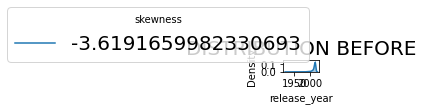

In [26]:
plt.subplot(16,8,10)
sns.distplot(df["release_year"])
plt.title("DISTRIBUTION BEFORE",fontsize=20)
skewness=str(df["release_year"].skew())
plt.legend([skewness],title="skewness",fontsize=20)